# Advanced Sentiment Shock & Signal Detection

This notebook detects statistically significant **sentiment shocks** for each ticker based on the
sentiment analysis results stored in Oracle database.

**Goals:**
- Load sentiment data from Oracle `sentiment_results` table
- Detect statistically significant sentiment shocks for each ticker  
- Use a sliding window over several days to smooth short-term sentiment  
- Make the significance threshold dynamic based on how often the ticker is mentioned  
- Classify shocks into **BUY / SELL** trading signals  
- Provide visualizations and document the methodology directly in the code comments  

**Input:**
- Oracle database table `sentiment_results` – output from the sentiment analysis pipeline

**Requirements:**
- `.env` file with Oracle database credentials (db-dsn, db-username, db-password)
- `utils.py` with `get_oracle_connection()` function

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import os
from dotenv import load_dotenv
load_dotenv()

# Import Oracle database connection from utils
from utils import get_oracle_connection

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True

print("Imports ready")

Imports ready


In [67]:
# =============================================================================
# CONFIG
# =============================================================================

# Output file for signals
OUTPUT_FILE = "sentiment_signals_advanced.csv"

# Sliding window for "current" sentiment shock
WINDOW_DAYS = 3              # how many days we aggregate over for the shock

# Baseline window for historical average/volatility
BASELINE_DAYS = 30           # rolling window to estimate "normal" sentiment
MIN_BASELINE_DAYS = 15       # minimum history to start evaluating shocks

# Minimum volume of discussion needed in the window
MIN_MENTIONS_IN_WINDOW = 5   # too few mentions = ignore (low information)

# Base z-score threshold (if mentions are "normal")
BASE_Z_THRESHOLD = 1.8       # ~1.8–2.0 is a decent trade-off

# Dynamic adjustment of threshold based on mention volume
# If a ticker is mentioned way more than usual, we lower the threshold slightly
VOLUME_SENSITIVITY = 0.3     # how much volume affects threshold (0.0 = no effect, 1.0 = strong)

# Additional parameters for signal generation
MIN_ABS_SENT_CHANGE = 0.1    # minimum absolute sentiment change to generate signal
MENTION_SENSITIVITY = 0.2    # how much mention volume affects threshold

# Tickers to plot for visualization (will be updated after data load)
PLOT_TICKERS = ['AAPL', 'TSLA', 'GOOGL']  # default tickers for plotting

print("Configuration loaded - connecting to Oracle database for sentiment_results")

Configuration loaded - connecting to Oracle database for sentiment_results


In [68]:
# =============================================================================
# 1) LOAD SENTIMENT DATA FROM ORACLE DATABASE
# =============================================================================

# Simple Oracle connection and data loading
conn = get_oracle_connection()

if not conn:
    raise ConnectionError("Failed to connect to Oracle database. Check your .env file.")

# Load sentiment_results table with correct column names (excluding SENTIMENT_READY_TEXT)
query = """
SELECT ticker, created_utc, final_sentiment_score, normalized_upvotes, 
       final_sentiment_label, source_model, tw_confidence, subreddit, 
       type, text_length, word_count
FROM sentiment_results
"""
df_original = pd.read_sql_query(query, conn)



conn.close()

print(f"✅ Loaded {len(df_original):,} rows from sentiment_results table")
print(f"Columns: {list(df_original.columns)}")
print(f"Shape: {df_original.shape}")
print("Ready for analysis!")

Oracle connection successful!


C:\Users\malic\AppData\Local\Temp\ipykernel_27084\705263982.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_original = pd.read_sql_query(query, conn)


✅ Loaded 674,889 rows from sentiment_results table
Columns: ['TICKER', 'CREATED_UTC', 'FINAL_SENTIMENT_SCORE', 'NORMALIZED_UPVOTES', 'FINAL_SENTIMENT_LABEL', 'SOURCE_MODEL', 'TW_CONFIDENCE', 'SUBREDDIT', 'TYPE', 'TEXT_LENGTH', 'WORD_COUNT']
Shape: (674889, 11)
Ready for analysis!


In [69]:
df = df_original.copy()  # Work on a copy for analysis
df.head()

,TICKER,CREATED_UTC,FINAL_SENTIMENT_SCORE,NORMALIZED_UPVOTES,FINAL_SENTIMENT_LABEL,SOURCE_MODEL,TW_CONFIDENCE,SUBREDDIT,TYPE,TEXT_LENGTH,WORD_COUNT
0,AMZN,1709799178,-0.7810,0.0516,negative,RoBERTa,0.7926,stocks,comment,252,50
1,ARM,1709799178,-0.7521,0.0516,negative,RoBERTa,0.7659,stocks,comment,252,50
2,DELL,1709799178,-0.7509,0.0516,negative,RoBERTa,0.7643,stocks,comment,252,50
3,FOUR,1709799178,-0.7502,0.0516,negative,RoBERTa,0.7631,stocks,comment,252,50
4,GOOG,1709799178,-0.7919,0.0516,negative,RoBERTa,0.8042,stocks,comment,252,50


In [70]:
# =============================================================================
# 2) PREPARE DAILY AGGREGATED SENTIMENT
# =============================================================================
"""
We go from (many rows per ticker & day) -> (one row per ticker & day)
Metrics per day:
    - sentiment_mean: mean of final_sentiment_score weighted by normalized_upvotes
    - sentiment_median: median (robust to outliers)
    - mentions: how many mentions that day
    - total_upvotes: sum of normalized upvotes for weighting
"""

# Convert Oracle column names to lowercase for easier handling
df.columns = df.columns.str.lower()

# Convert UTC timestamp to proper datetime
print("Converting UTC timestamp to datetime...")
if df['created_utc'].dtype == 'object':
    # If it's string format, convert to datetime with UTC awareness
    df["created_utc"] = pd.to_datetime(df["created_utc"], utc=True)
else:
    # If it's numeric (Unix timestamp), convert from Unix timestamp
    df["created_utc"] = pd.to_datetime(df["created_utc"], unit='s', utc=True)

# Extract date for daily aggregation
df["date"] = df["created_utc"].dt.date

# Create weighted sentiment (sentiment * normalized_upvotes)
df["weighted_sentiment"] = df["final_sentiment_score"] * df["normalized_upvotes"]

daily = (
    df.groupby(["ticker", "date"])
      .agg(
          # Weighted average: sum(sentiment * upvotes) / sum(upvotes)
          sentiment_mean=("weighted_sentiment", "sum"),
          total_upvotes=("normalized_upvotes", "sum"),
          sentiment_median=("final_sentiment_score", "median"),
          mentions=("final_sentiment_score", "count")
      )
      .reset_index()
)

# Calculate upvote-weighted sentiment mean
daily["sentiment_mean"] = daily["sentiment_mean"] / daily["total_upvotes"].replace(0, np.nan)

# Fill NaN with regular mean where upvotes are zero
mask_zero_upvotes = daily["total_upvotes"] == 0
if mask_zero_upvotes.any():
    print(f"Warning: {mask_zero_upvotes.sum()} days have zero upvotes, using median sentiment")
    daily.loc[mask_zero_upvotes, "sentiment_mean"] = daily.loc[mask_zero_upvotes, "sentiment_median"]

daily["date"] = pd.to_datetime(daily["date"])
daily = daily.sort_values(["ticker", "date"])

print(f"Built daily sentiment dataframe with {len(daily):,} rows")
print(f"Date range: {daily['date'].min()} to {daily['date'].max()}")
print(f"Average upvotes per day: {daily['total_upvotes'].mean():.2f}")
daily.head()

Converting UTC timestamp to datetime...
Built daily sentiment dataframe with 90,280 rows
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Average upvotes per day: 0.57


,ticker,date,sentiment_mean,total_upvotes,sentiment_median,mentions
0,AACG,2024-06-09,-0.654300,0.0595,-0.6543,1
1,AACI,2024-01-05,-0.159800,0.1231,-0.1598,1
2,AAL,2024-01-04,0.653400,0.0510,0.6534,1
3,AAL,2024-01-07,0.946300,0.0509,0.9463,1
4,AAL,2024-01-14,0.384882,0.3695,0.2293,3


In [71]:
# =============================================================================
# 3) CORE FUNCTION: COMPUTE SHOCKS & SIGNALS PER TICKER
# =============================================================================

def compute_shocks_for_ticker(df_ticker: pd.DataFrame) -> pd.DataFrame:
    """
    Compute sentiment shocks and trading signals for a single ticker.

    Steps per ticker:
        1) Compute sliding window sentiment over WINDOW_DAYS (window_mean)
        2) Compute rolling baseline mean/std over BASELINE_DAYS (excluding early days)
        3) Compute z-score of window_mean vs. baseline
        4) Adjust z-threshold based on total mentions in the window
        5) Generate BUY / SELL signals if:
               - |z_score| >= dynamic_threshold
               - |sentiment change| >= MIN_ABS_SENT_CHANGE
               - mentions_window >= MIN_MENTIONS_IN_WINDOW
    """

    df_t = df_ticker.copy().sort_values("date")

    # Sliding window over DAYS (not rows) – easier with rolling on daily index
    df_t = df_t.set_index("date")

    # Ensure regular daily index (fill missing days with NaNs for mentions/sentiment)
    full_idx = pd.date_range(df_t.index.min(), df_t.index.max(), freq="D")
    df_t = df_t.reindex(full_idx)
    df_t.index.name = "date"

    # Forward-fill ticker, mentions for missing days
    df_t["ticker"] = df_t["ticker"].ffill().bfill()  # ticker constant
    df_t["mentions"] = df_t["mentions"].fillna(0)

    # Sliding window sentiment = weighted average over last WINDOW_DAYS using mentions
    roll_mentions = df_t["mentions"].rolling(WINDOW_DAYS, min_periods=1).sum()

    # For sentiment, we use a mention-weighted average in the window
    df_t["sent_weighted"] = df_t["sentiment_mean"] * df_t["mentions"]
    roll_sent_sum = df_t["sent_weighted"].rolling(WINDOW_DAYS, min_periods=1).sum()
    roll_sent_mean = roll_sent_sum / roll_mentions.replace(0, np.nan)

    df_t["window_sentiment"] = roll_sent_mean
    df_t["window_mentions"] = roll_mentions

    # Baseline: rolling mean & std of window_sentiment over long horizon
    baseline_mean = df_t["window_sentiment"].rolling(
        BASELINE_DAYS, min_periods=MIN_BASELINE_DAYS
    ).mean()
    baseline_std = df_t["window_sentiment"].rolling(
        BASELINE_DAYS, min_periods=MIN_BASELINE_DAYS
    ).std()

    df_t["baseline_mean"] = baseline_mean
    df_t["baseline_std"] = baseline_std

    # Z-score of current window sentiment vs historical baseline
    df_t["z_score"] = (df_t["window_sentiment"] - df_t["baseline_mean"]) / df_t["baseline_std"]

    # Dynamic z-threshold based on mentions in window
    mention_factor = np.log1p(df_t["window_mentions"].clip(lower=1.0))
    df_t["z_threshold"] = BASE_Z_THRESHOLD / (1 + MENTION_SENSITIVITY * mention_factor)

    # Absolute change vs baseline_mean
    df_t["abs_sent_change"] = (df_t["window_sentiment"] - df_t["baseline_mean"]).abs()

    # Initialize signals
    df_t["signal"] = "NONE"
    df_t["signal_direction"] = np.nan  # +1 = BUY, -1 = SELL
    df_t["signal_score"] = np.nan      # strength proxy (z-score)

    # Conditions for signals:
    cond_valid_baseline = df_t["baseline_std"].notna()
    cond_enough_mentions = df_t["window_mentions"] >= MIN_MENTIONS_IN_WINDOW
    cond_abs_move = df_t["abs_sent_change"] >= MIN_ABS_SENT_CHANGE

    # BUY: sentiment significantly above baseline, positive direction
    cond_buy = (
        cond_valid_baseline &
        cond_enough_mentions &
        cond_abs_move &
        (df_t["z_score"] >= df_t["z_threshold"]) &
        (df_t["window_sentiment"] > 0)
    )

    # SELL: sentiment significantly below baseline, negative direction
    cond_sell = (
        cond_valid_baseline &
        cond_enough_mentions &
        cond_abs_move &
        (df_t["z_score"] <= -df_t["z_threshold"]) &
        (df_t["window_sentiment"] < 0)
    )

    df_t.loc[cond_buy, "signal"] = "BUY"
    df_t.loc[cond_buy, "signal_direction"] = 1
    df_t.loc[cond_buy, "signal_score"] = df_t.loc[cond_buy, "z_score"]

    df_t.loc[cond_sell, "signal"] = "SELL"
    df_t.loc[cond_sell, "signal_direction"] = -1
    df_t.loc[cond_sell, "signal_score"] = df_t.loc[cond_sell, "z_score"]

    # Reset index back to columns
    df_t = df_t.reset_index()

    return df_t

print("Function compute_shocks_for_ticker() defined")

Function compute_shocks_for_ticker() defined


In [72]:
# =============================================================================
# 4) APPLY TO ALL TICKERS
# =============================================================================

all_tickers = daily["ticker"].unique()
print(f"Tickers in dataset: {len(all_tickers)}")

results = []

for t in all_tickers:
    df_t = daily[daily["ticker"] == t].copy()
    shocks = compute_shocks_for_ticker(df_t)
    shocks["ticker"] = t
    results.append(shocks)

signals_df = pd.concat(results, ignore_index=True)

# Keep only rows where there is an actual signal
signals_only = signals_df[signals_df["signal"] != "NONE"].copy()

print(f"Detected {len(signals_only):,} BUY/SELL signals across all tickers.")
signals_only[["ticker", "date", "signal", "signal_score", "window_sentiment", "window_mentions"]].head()

Tickers in dataset: 4129
Detected 5,896 BUY/SELL signals across all tickers.


,ticker,date,signal,signal_score,window_sentiment,window_mentions
206,AAL,2024-07-26,SELL,-1.517058,-0.482514,81.0
207,AAL,2024-07-27,SELL,-1.387834,-0.485157,88.0
208,AAL,2024-07-28,SELL,-1.222935,-0.485762,79.0
1333,AAP,2024-10-31,BUY,1.337983,0.514008,6.0
1420,AAPL,2024-01-16,BUY,1.843550,0.117852,231.0


In [73]:
# =============================================================================
# 5) SAVE SIGNALS
# =============================================================================

signals_only.to_csv(OUTPUT_FILE, index=False)
print(f"Saved advanced signals to: {OUTPUT_FILE}")

Saved advanced signals to: sentiment_signals_advanced.csv


In [76]:
# =============================================================================
# EXPORT RESULTS TO ORACLE DATABASE
# =============================================================================

def export_signals_to_oracle(signals_df, table_suffix="SIGNALS"):
    """
    Streamlined function to export sentiment signals to Oracle database.
    
    Args:
        signals_df: DataFrame with sentiment analysis results
        table_suffix: Suffix for the table name (default: "SIGNALS")
    
    Returns:
        str: Name of created table, or None if export failed
    """
    
    print(f"🚀 Exporting sentiment signals to Oracle database...")
    
    # Connect to Oracle
    conn = get_oracle_connection()
    if not conn:
        print("❌ Failed to connect to Oracle database.")
        return None
    
    try:
        # 1. Filter and prepare data
        export_df = signals_df[signals_df['signal'].isin(['BUY', 'SELL'])].copy()
        print(f"📊 Filtered to {len(export_df):,} BUY/SELL signals (excluding {len(signals_df) - len(export_df):,} NONE signals)")
        
        # 2. Clean data for Oracle compatibility
        export_df['date'] = export_df['date'].dt.strftime('%Y-%m-%d')
        export_df['signal'] = export_df['signal'].astype(str)
        
        # Replace inf/-inf and NaN with None
        for col in export_df.select_dtypes(include=[np.number]).columns:
            export_df[col] = export_df[col].replace([np.inf, -np.inf], np.nan)
            export_df[col] = export_df[col].where(pd.notnull(export_df[col]), None)
        
        # 3. Create table
        table_name = f"SENTIMENT_{table_suffix}"
        
        cursor = conn.cursor()
        
        # Drop existing table if any
        try:
            cursor.execute(f"DROP TABLE {table_name}")
        except:
            pass
        
        # Create table with predefined structure
        create_sql = f"""
        CREATE TABLE {table_name} (
            SIGNAL_DATE VARCHAR2(20),
            TICKER VARCHAR2(20),
            SENTIMENT_MEAN NUMBER(15,6),
            TOTAL_UPVOTES NUMBER(15,6),
            WINDOW_SENTIMENT NUMBER(15,6),
            WINDOW_MENTIONS NUMBER(15,6),
            Z_SCORE NUMBER(15,6),
            SIGNAL_TYPE VARCHAR2(10),
            SIGNAL_DIRECTION NUMBER(3,0),
            SIGNAL_SCORE NUMBER(15,6)
        )
        """
        
        cursor.execute(create_sql)
        print(f"✅ Created Oracle table: {table_name}")
        
        # 4. Prepare and insert data
        column_mapping = [
            ('date', str),
            ('ticker', str),
            ('sentiment_mean', float),
            ('total_upvotes', float),
            ('window_sentiment', float),
            ('window_mentions', float),
            ('z_score', float),
            ('signal', str),
            ('signal_direction', int),
            ('signal_score', float)
        ]
        
        insert_sql = f"""
        INSERT INTO {table_name} (
            SIGNAL_DATE, TICKER, SENTIMENT_MEAN, TOTAL_UPVOTES,
            WINDOW_SENTIMENT, WINDOW_MENTIONS, Z_SCORE,
            SIGNAL_TYPE, SIGNAL_DIRECTION, SIGNAL_SCORE
        ) VALUES (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10)
        """
        
        # Convert data to proper types
        data_rows = []
        for _, row in export_df.iterrows():
            values = []
            for col_name, col_type in column_mapping:
                val = row[col_name]
                
                if val is None or (isinstance(val, float) and (np.isnan(val) or np.isinf(val))):
                    values.append(None)
                elif col_type == str:
                    values.append(str(val))
                elif col_type == int:
                    values.append(None if val is None else int(val))
                elif col_type == float:
                    values.append(None if val is None else float(val))
                else:
                    values.append(val)
            
            data_rows.append(tuple(values))
        
        # 5. Batch insert
        batch_size = 1000
        for i in range(0, len(data_rows), batch_size):
            batch = data_rows[i:i + batch_size]
            cursor.executemany(insert_sql, batch)
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"  📈 Inserted {i + len(batch):,} / {len(data_rows):,} rows...")
        
        conn.commit()
        
        # 6. Summary
        buy_count = len([r for r in data_rows if r[7] == 'BUY'])
        sell_count = len([r for r in data_rows if r[7] == 'SELL'])
        
        print(f"✅ Successfully exported {len(data_rows):,} trading signals to Oracle!")
        print(f"   📊 Table: {table_name}")
        print(f"   🟢 BUY signals: {buy_count:,}")
        print(f"   🔴 SELL signals: {sell_count:,}")
        
        return table_name
        
    except Exception as e:
        print(f"❌ Export failed: {e}")
        import traceback
        traceback.print_exc()
        return None
        
    finally:
        if 'cursor' in locals():
            cursor.close()
        conn.close()

# Execute the export
print("=" * 60)
exported_table = export_signals_to_oracle(signals_df, "SIGNALS")
if exported_table:
    print(f"🎉 Export completed successfully! Table: {exported_table}")
else:
    print("❌ Export failed. Please check the error messages above.")
print("=" * 60)

🚀 Exporting sentiment signals to Oracle database...
Oracle connection successful!
📊 Filtered to 5,896 BUY/SELL signals (excluding 772,980 NONE signals)
✅ Created Oracle table: SENTIMENT_SIGNALS
✅ Successfully exported 5,896 trading signals to Oracle!
   📊 Table: SENTIMENT_SIGNALS
   🟢 BUY signals: 2,424
   🔴 SELL signals: 3,472
🎉 Export completed successfully! Table: SENTIMENT_SIGNALS


Generating example plots for selected tickers...


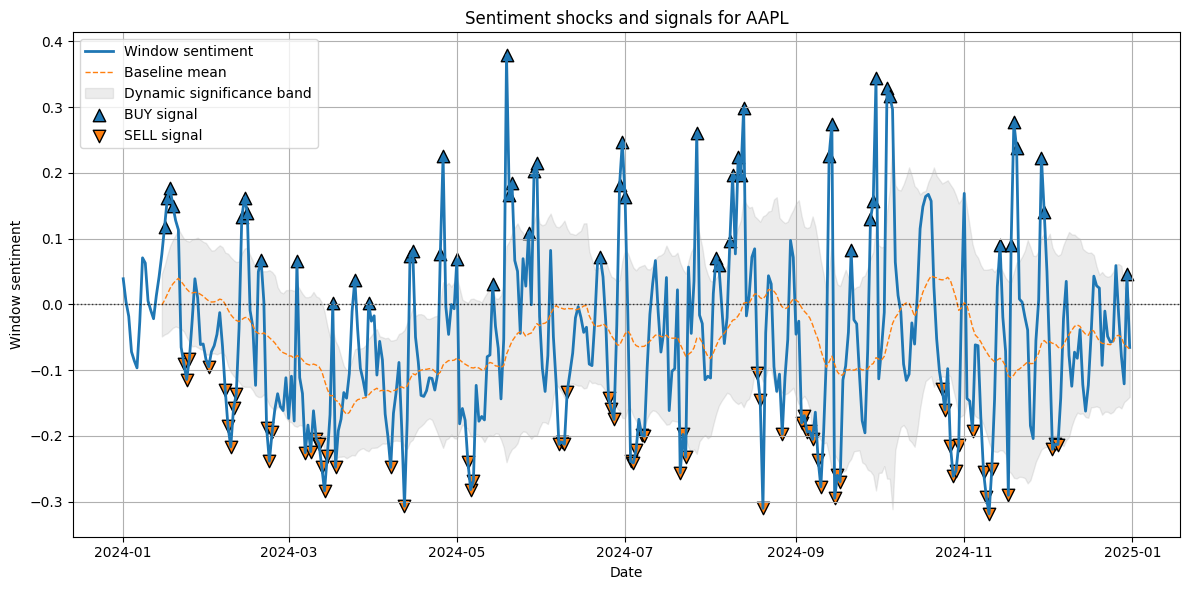

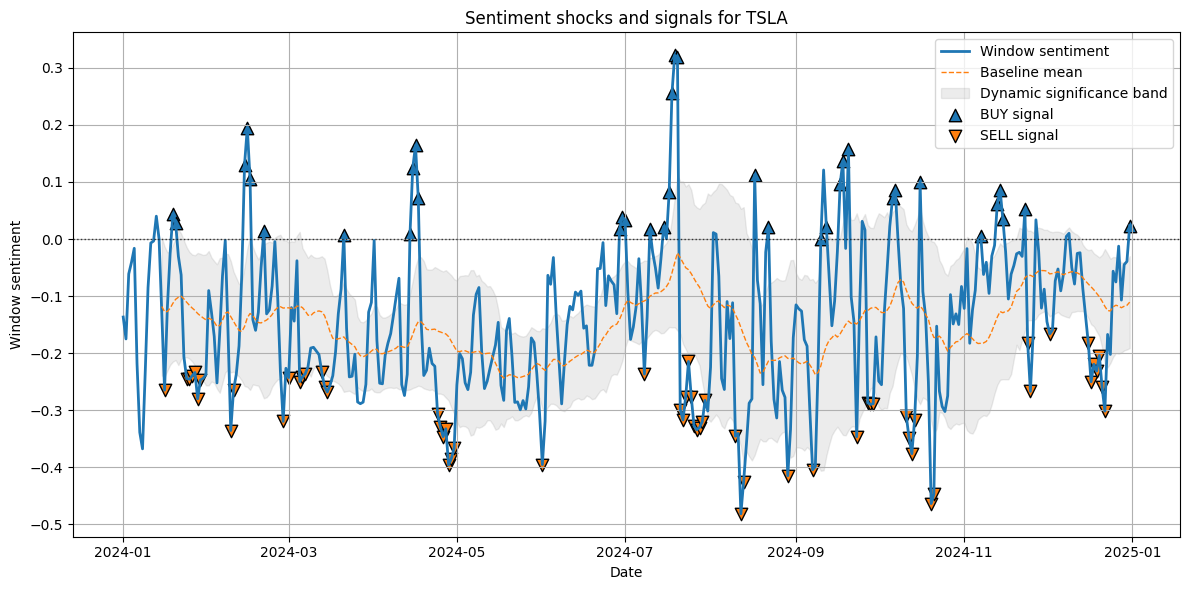

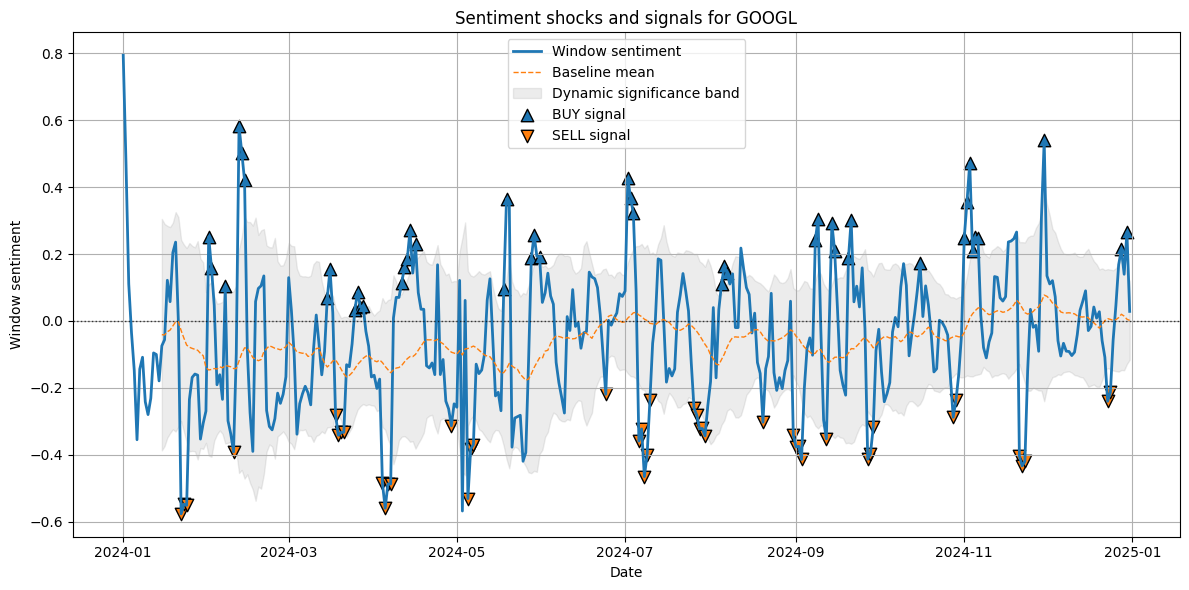

Done.


In [75]:
# =============================================================================
# 6) VISUALIZATION – SENTIMENT SHOCKS FOR SELECTED TICKERS
# =============================================================================

def plot_ticker_sentiment_shocks(signals_df: pd.DataFrame, ticker: str):
    """
    Plot:
       - window_sentiment over time
       - baseline_mean
       - bands baseline_mean ± z_threshold * baseline_std
       - markers where BUY / SELL signals fired
    """

    df_t = signals_df[signals_df["ticker"] == ticker].copy()
    if df_t.empty:
        print(f"No data for ticker {ticker}")
        return

    df_t = df_t.sort_values("date")

    plt.figure(figsize=(12, 6))
    plt.title(f"Sentiment shocks and signals for {ticker}")
    plt.plot(df_t["date"], df_t["window_sentiment"], label="Window sentiment", linewidth=2)
    plt.plot(df_t["date"], df_t["baseline_mean"], label="Baseline mean", linestyle="--", linewidth=1)

    # Upper and lower dynamic bands
    upper_band = df_t["baseline_mean"] + df_t["z_threshold"] * df_t["baseline_std"]
    lower_band = df_t["baseline_mean"] - df_t["z_threshold"] * df_t["baseline_std"]
    plt.fill_between(df_t["date"], upper_band, lower_band, color="gray", alpha=0.15,
                     label="Dynamic significance band")

    # BUY/SELL markers
    buys = df_t[df_t["signal"] == "BUY"]
    sells = df_t[df_t["signal"] == "SELL"]

    plt.scatter(buys["date"], buys["window_sentiment"], marker="^", s=80,
                label="BUY signal", edgecolor="black")
    plt.scatter(sells["date"], sells["window_sentiment"], marker="v", s=80,
                label="SELL signal", edgecolor="black")

    plt.axhline(0, color="black", linestyle=":", linewidth=1, alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Window sentiment")
    plt.legend()
    plt.tight_layout()
    plt.show()


print("Generating example plots for selected tickers...")
for t in PLOT_TICKERS:
    plot_ticker_sentiment_shocks(signals_df, t)

print("Done.")